## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#I am setting the seed to assure getting the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
converted_users = df['converted'][df['converted'] == 1].count() / df['converted'].count()
converted_users

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
value = df['user_id'][(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')].count() + df['user_id'][(df['group'] != 'treatment') & (df['landing_page'] == 'new_page')].count()
value

3893

f. Do any of the rows have missing values?

**No, there are no missing values.**

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
correct_treatment = df[(df['group'] == 'treatment') & (df['landing_page'] == 'new_page')]
correct_lp = df[(df['group'] == 'control') & (df['landing_page'] == 'old_page')]
frames = [correct_lp, correct_treatment]
df2 = pd.concat(frames)
#df2 = correct_treatment.merge(correct_lp)
df2.shape

(290585, 5)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
duplicated_row = df2[df2.duplicated('user_id')]
duplicated_row

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [12]:
print(duplicated_row)

      user_id                   timestamp      group landing_page  converted
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
# dropping based on index number as we can see the information above.
df2 = df2.drop(2893).reset_index()

In [14]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 6 columns):
index           290584 non-null int64
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(3), object(3)
memory usage: 13.3+ MB


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
df2.query('landing_page == "new_page"').shape[0] / df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Comparing the conversion probabilities of control (12%) vs. treatment (11.88%) groups initially,
 seems like the new landing pages does not bring more conversions. Clearly further investigation is needed.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

                 H0: pnew - pold <= 0
                 H1: pnew - pold > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [21]:
n_new = df2.query('landing_page == "new_page"')['user_id'].nunique()
n_new

145310

d. What is $n_{old}$?

In [22]:
n_old = df2.query('landing_page == "old_page"')['user_id'].nunique()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.choice([0, 1], size=n_new, p=[1-p_new, p_new])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.choice([0, 1], size=n_old, p=[1-p_new, p_new])
old_page_converted

array([1, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
new_page_converted.mean() - old_page_converted.mean()

0.0006586263769169237

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [26]:
# I will do a sampling distribution for the conversion rate differences with boostrapping

p_diffs = []
size = df.shape[0]
for _ in range(10000):
    samp = df2.sample(size, replace = True)
    new_page_converted = np.random.choice([0,1],n_new, p=(p_new,1-p_new))
    old_page_converted = np.random.choice([0,1],n_old, p=(p_old,1-p_old))
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

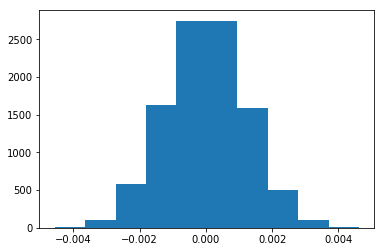

In [27]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
obs_diff = df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()
obs_diff

-0.0015782389853555567

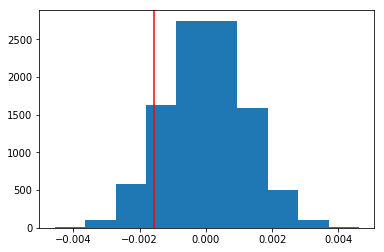

In [29]:
plt.hist(p_diffs)
plt.axvline(obs_diff, color='r')

In [30]:
p_diffs = np.array(p_diffs)
p_val = (p_diffs > obs_diff).mean()
p_val

0.9018

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

** What we've calculated on part j is p value. P value is calculated to understand the probability of observing our statistic or a more extreme statistic from the null hypothesis. 

As in this study Type 1 error rate was 5%, within this high p-value, we can say that we fail to reject the null hypothesis. With other words, the old page has equal or higher probability of conversions than the new page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm
from scipy.stats import norm

convert_old = len(df2[df2.landing_page == 'old_page'][df2.converted == 1])
convert_new = len(df2[df2.landing_page == 'new_page'][df2.converted == 1])
n_old, n_new, convert_new, convert_old 

C:\Users\eda.sanli\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\eda.sanli\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


(145274, 145310, 17264, 17489)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [32]:
z_score, p_value = z_score, p_value = z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z-value is obtained from a one-tail test as we are checking if two proportions are statistically worse-than each other. Because z-value of -1.31 is not higher than 95% confidence, we fail to reject the null hypothesis.
The p-value of 0.91 is larger than 0.05 and so we also fail to reject the null hypothesis using the p-value. 
In other words, we can say that the conclusion is not different from the findings in par j and k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**As logistic regression predicts one of two values, we could use it here.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [33]:
df2.head()

,index,user_id,timestamp,group,landing_page,converted
0,0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,4,864975,2017-01-21 01:52:26.210827,control,old_page,1
3,5,936923,2017-01-10 15:20:49.083499,control,old_page,0
4,7,719014,2017-01-17 01:48:29.539573,control,old_page,0


In [34]:
df2['intercept'] = 1
df2[['drop', 'ab_page']] = pd.get_dummies(df2['group'])
df2.drop('drop', axis=1, inplace=True)

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [35]:
logis_reg = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logis_reg.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 12 Apr 2020   Pseudo R-squ.:               8.077e-06
Time:                        13:01:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**P value above is 0.190. The reason why it differes from Part II is because we analyze different null hypotheses. In Part II, the null hypothesis was the old page has equal or higher conversions than the new page. Here in Part III though, our null hypothesis is old page brings equal conversions to the new page. Again in Part III, because p-value is higher than 5%, we again reject the null hypothesis and accept that old page does not bring equal conversions as the new page.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**It's clearly a good idea to add other factors into the model to understand how these factors influence people to convert or not convert. One things can be considered here is the timestamp to predict on which time of the day is more likely "converted". Another example could be gender to see if there is a significant behavior difference between men and women. 
There might be two disadvantages of additional factors in the model:
    1. It's harder to interpret the results with additional, explanatory variables
    2. Additional factors might cause multicollinearity problems (where certain variables are related to the response but not to each other). 
    3. With additional values, we might have more outliers and it might break the model.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [37]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [38]:
### Create the necessary dummy variables
df_new[['drop', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.drop('drop', axis=1, inplace=True)
df_new.head(10)

,country,index,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,,,
834778,UK,143206,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,157345,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,257177,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,48778,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,106686,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0
909908,UK,120612,2017-01-06 20:44:26.334764,treatment,new_page,0,1,1,1,0
811617,US,130400,2017-01-02 18:42:11.851370,treatment,new_page,1,1,1,0,1
938122,US,168052,2017-01-10 09:32:08.222716,treatment,new_page,1,1,1,0,1
887018,US,111071,2017-01-06 11:09:40.487196,treatment,new_page,0,1,1,0,1


In [39]:
logit = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'US']])
results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 12 Apr 2020   Pseudo R-squ.:               1.521e-05
Time:                        13:01:35   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [40]:
### Fit Your Linear Model And Obtain the Results
np.exp(results.params)

intercept    0.130350
UK           1.052027
US           1.041647
dtype: float64

**All p-values above are above 0.05, therefore we can interpret that they are not statistically significant to predict the user conversions.**

<a id='conclusions'></a>
## Conclusions

In this project, we analyse whether the new page this company created brings more conversions or not, and whether they should implement this new page. 

- After we make the initial analyses, we built our first null hypothesis in Part II and said that old page is equal or more convertible than the new page. After the getting results p-value of 0.906, we failed to reject the null hypothesis. Along with that, we also checked z-value but that also led us to fail to reject the null hypothesis. 

- We then continued by implementing the logistic regression to calculate the p-value but again, we couldn't reject the null hypothesis. 

- Finally, we wanted to extend the analysis by adding countries as additional variable to the model, however, there was no statistically significant result to showcase that country is a factor to influence the conversion rate. 

We can conclude this analysis by saying that there is no statistical evidence that the new page has better conversions rate and the company should not implement this new page into their website. 


### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.